In [1]:
import os
import glob
import requests
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import h5py
from osgeo import gdal,osr
from zeep import Client, Settings
from pprint import pprint
import zeep
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import DateFormatter
import matplotlib.path as mpltPath
from scipy.interpolate import RegularGridInterpolator
import json as js
import re
import setParams as p
from scipy.spatial import ConvexHull

In [ ]:
fp_anciStatic       = '/scratch/rlohman/static/NISAR_SM_STATIC_ANCILLARY_002.h5'
workDir             = p.workDir
modDirs             = (workDir+'products/retrievals/',workDir+'R4/')
newDir              = '/scratch/rlohman/'+p.areaName+'/Path'+str(p.path)+'Frame'+str(p.frame)+'Beam'+p.beam+'logNorm/products/retrievals/'
modDirs             = (workDir+'products/retrievals/',workDir+'R4/',newDir)
print(workDir)

/scratch/rlohman/WalnutGulchA/Path62Frame620BeamFP66/


In [3]:
outFiles     = np.array(glob.glob(modDirs[0]+('[0-9]'*8)+'.h5'))

# #find index of begin/end of dates, assume format same for all
tmp          = re.search(r'2[0-9]{7}',outFiles[0])
inds         = tmp.span()
dates        = np.array([datetime.datetime.strptime(x[inds[0]:inds[1]],'%Y%m%d') for x in outFiles])

sort_index   = np.argsort(dates)
gcovs        = outFiles[sort_index]
dates        = dates[sort_index]


allgcovs      = np.reshape([dirName+os.path.basename(x) for dirName in modDirs for x in gcovs],[len(modDirs),len(dates)])

year0        = dates[0].year
yearN        = dates[-1].year
print(str(len(dates))+' dates in list')

46 dates in list


In [4]:
#read in first date, DSG algorithm, to construct bounding polygon

fo  = h5py.File(allgcovs[0,0],'r')
lat = fo['/science/LSAR/SME2/grids/latitude'][()]
lon = fo['/science/LSAR/SME2/grids/longitude'][()]
eci = fo['/science/LSAR/SME2/grids/EASEGridColumnIndex'][()]
eri = fo['/science/LSAR/SME2/grids/EASEGridRowIndex'][()]
ret = fo['/science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture'][()] #for plotting only
fo.close()

long,latg = np.meshgrid(lon,lat)
good      = np.isfinite(ret)
lat1      = latg[good].flatten()
lon1      = long[good].flatten()
points    = np.array([lat1,lon1]).T

tmp       = ConvexHull(points)
footprint = np.array([points[tmp.vertices,0],points[tmp.vertices,1]]).T #lat,lon of non-nan region

In [5]:
#API lets us search min/max long/lat, not polygon
minLatitude  = np.min(footprint[:,0])
maxLatitude  = np.max(footprint[:,0])
minLongitude = np.min(footprint[:,1])
maxLongitude = np.max(footprint[:,1])

In [6]:
NRCS_AWDB_SOAP_WSDL_URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"
NRCS_AWDB_REST_DATA_ENDPOINT = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data"

In [7]:
settings         = Settings(strict=False, xml_huge_tree=True)
client           = Client(NRCS_AWDB_SOAP_WSDL_URL,settings=settings)
station_triplets = client.service.getStations(elementCds='SMS',minLatitude=minLatitude,maxLatitude=maxLatitude,minLongitude=minLongitude,maxLongitude=maxLongitude, logicalAnd=True)
print(str(len(station_triplets))+' stations in footprint')

1 stations in footprint


In [8]:
data  = client.service.getStationMetadataMultiple(stationTriplets=station_triplets)
df    = pd.DataFrame.from_records(zeep.helpers.serialize_object(data))
ptlon = df.longitude.to_numpy().astype('float')
ptlat = df.latitude.to_numpy().astype('float')

In [9]:
path = mpltPath.Path(footprint)
pt   = [[ptlat[0],ptlon[0]]]
inside = path.contains_points(pt)
print('Is point actually in polygon?:',inside[0])

Is point actually in polygon?: True


In [10]:
#load landcover data
f_a      = h5py.File(fp_anciStatic,'r')
srs     = osr.SpatialReference()
srs.ImportFromEPSG(4326) #EASEGRID 2.0

map_scale_m = 200.17900466991
cols        = 173520
rows        = 73080
col0        = (cols-1)/2
row0        = (rows-1)/2

EASEsrs     = osr.SpatialReference()
EASEsrs.ImportFromEPSG(6933) #EASEGRID 2.0
transform   = osr.CoordinateTransformation(srs, EASEsrs) #transform from Lat/Lon (4326) to EASE
coords      = transform.TransformPoint(ptlat[0],ptlon[0]) 
ptezr       = np.ceil(row0-coords[1]/map_scale_m-0.5).astype('int')
ptezc       = np.ceil(col0+coords[0]/map_scale_m-0.5).astype('int')

lulc        = f_a['/landCover200m'][ptezr,ptezc]
print('lulc=',lulc)
f_a         = None

lulc= 2


In [11]:
idx = np.array([np.linalg.norm(x) for x in eci-ptezc]).argmin()
idy = np.array([np.linalg.norm(x) for x in eri-ptezr]).argmin()
print(lon[idx],lat[idy],ptezr,ptezc,idx,idy)
retr= np.zeros([len(modDirs),len(gcovs),3])*np.nan
rete= np.zeros([len(modDirs),len(gcovs),3])*np.nan
HH  = np.zeros([len(modDirs),len(gcovs)])*np.nan
mods=('DSG','PMI','TSR')
for j in range(len(modDirs)):
    for i in range(len(dates)):
            if os.path.isfile(allgcovs[j,i]):
                fo=h5py.File(allgcovs[j,i],'r')
                dataset='/science/LSAR/SME2/grids/radarData/frequencyA/sigma0HH'
                if dataset in fo:
                    HH[j,i] =fo[dataset][idy,idx]

                for k in range(len(mods)):
                    dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[k]+'/soilMoisture'
                    if dataset in fo:
                        retr[j,i,k] =fo[dataset][idy,idx]
                for k in range(len(mods)):
                    dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[k]+'/soilMoistureUncertainty'
                    if dataset in fo:
                        rete[j,i,k] =fo[dataset][idy,idx]
                
                fo.close()
retr[retr<0] = np.nan
rete[rete<0] = np.nan
HH[HH<0]     = np.nan

-110.05083 31.743279 17305 33715 190 115


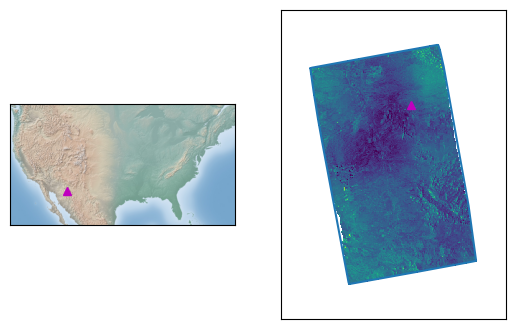

In [12]:
fig,axes = plt.subplots(1,2)
# CONUS basemap
m = Basemap(projection='merc',llcrnrlat=24,urcrnrlat=49,llcrnrlon=-125,urcrnrlon=-66,lat_ts=35,resolution=None,ax=axes[0])
m.shadedrelief()
m.plot(np.append(footprint[:,0],footprint[0,0]),np.append(footprint[:,1],footprint[0,1]),'g',latlon=True)
m.plot(ptlon,ptlat,'m^',latlon=True)

#zoom in version
m = Basemap(projection='merc',llcrnrlat=minLatitude-0.1,urcrnrlat=maxLatitude+0.1,llcrnrlon=minLongitude-0.1,urcrnrlon=maxLongitude+0.1,lat_ts=np.mean(footprint[:,0]),resolution='i',ax=axes[1])
m.drawcoastlines()
m.drawstates()
m.pcolor(long,latg,ret,latlon=True)
m.plot(np.append(footprint[:,1],footprint[0,1]),np.append(footprint[:,0],footprint[0,0]),latlon=True)
m.plot(ptlon,ptlat,'m^',latlon=True)
plt.show()

In [13]:
ELEMENT_CODES = ("SMS:*")# Soil Moisture PERCENT
DURATION = "DAILY"

In [14]:
def build_awdb_data_query_string(
    station_triplet: str,
    begin_date: str,
    end_date: str,
    elements: tuple[str, ...],
    duration: str,
):
    """Build querystring for the AWDB REST /data endpoint to get station data."""
    return "&".join(
        [
            f"stationTriplets={station_triplet}",
            f"beginDate={begin_date}",
            f"endDate={end_date}",
            "elements=SMS%3A%2A",
            f"duration={duration}",
        ]
    )

def _series_from_date_value_dicts(arr: list[dict]):
    """Utility to build a pandas Series from the {"date": ..., "value": ...} JSON records returned
    by the AWDB REST Service data/ endpoint.
    """
    dates, values = zip(*[(entry["date"], entry["value"]) for entry in arr])
    return pd.Series(values, index=dates, dtype="float")

def get_data_for_station(station_triplet: str, begin_date: datetime.date, end_date: datetime.date) -> pd.DataFrame:
    """Returns data from NRCS AWDB for a station over given date range."""
    if type(station_triplet) is list:
        if len(station_triplet) > 1 :
            station_triplet=','.join(station_triplet)

    url = (
        NRCS_AWDB_REST_DATA_ENDPOINT
        + "?"
        + build_awdb_data_query_string(
            station_triplet=station_triplet,
            begin_date=begin_date.strftime("%Y-%m-%d"),
            end_date=end_date.strftime("%Y-%m-%d"),
            elements=ELEMENT_CODES,
            duration=DURATION,
        )
    )
    print(url)
    session = requests.Session()
    response = session.get(url)

    if response.status_code == 200:
        if len(response.json())>0:
            data = {
                entry["stationElement"]["elementCode"]
                + "_"
                + entry["stationElement"]["durationName"]: _series_from_date_value_dicts(entry["values"])
                for entry in response.json()[0]["data"]
            }
            df = pd.DataFrame(data)
            df.index.name = "date"
        else:
            print('No data found')
            df = pd.DataFrame()
    else:
        print('Error at site')
        df = pd.DataFrame()
    return df

In [15]:
begin_date         = dates[0]+timedelta(days=-7)
end_date           = dates[-1]+timedelta(days=7)
data_df            = get_data_for_station(station_triplets[0], begin_date, end_date)

dfdates            = data_df.index.values
dfdn               = np.array([datetime.datetime.strptime(x,'%Y-%m-%d') for x in dfdates])

maxdays            = 7
dd                 = np.array([np.abs(x-dfdn) for x in dates]).astype('timedelta64[D]').astype(int)

ddmin              = np.min(dd,1)
indices            = np.argmin(dd, axis=1)
bigGap             = np.argwhere(ddmin>=maxdays)
insituDates        = dfdn[indices]
insituData         = data_df['SMS_DAILY'][indices].values
insituData[bigGap] = np.nan

minval             = np.nanmin([np.nanmin(data_df['SMS_DAILY'].values),np.nanmin(retr*100,axis=None)])-2
maxval             = np.nanmax([np.nanmax(data_df['SMS_DAILY'].values),np.nanmax(retr*100,axis=None)])+2


https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data?stationTriplets=2026:AZ:SCAN&beginDate=2021-07-25&endDate=2024-04-14&elements=SMS%3A%2A&duration=DAILY


In [16]:
cols=('r','g','b')
symbs=('.','+','^')

In [17]:
print('Std dev of inSitu Data:',np.nanstd(insituData/100,ddof=1))
res               = retr-np.tile(np.reshape(insituData/100,[len(dates),1]),[len(modDirs),1,len(mods)])
bias              = np.nanmean(res,axis=1)

#just points where all algs are defined
allGoodId         = np.argwhere(np.isfinite(np.sum(np.sum(res,axis=2),axis=0))==1).flatten()
res2              = res[:,allGoodId,:]
bias2             = np.nanmean(res2,axis=1)

ubres   = np.zeros([len(modDirs),len(dates),len(mods)])
UBRMSE1 = np.zeros([len(modDirs),len(mods)])
UBRMSE2 = np.zeros([len(modDirs),len(mods)])
stddev1 = np.zeros([len(modDirs),len(mods)])
stddev2 = np.zeros([len(modDirs),len(mods)])
for i in range(len(modDirs)):
    for j in range(3):
        count1        = np.sum(np.isfinite(res[i,:,j]))     
        count2        = np.sum(np.isfinite(res2[i,:,j]))
        ubres[i,:,j]  = res[i,:,j] -bias[i,j]

        UBRMSE1[i,j]  = np.sqrt(np.nansum(ubres[i,:,j]**2)/count1)
        UBRMSE2[i,j]  = np.sqrt(np.nansum((res2[i,:,j]-bias2[i,j])**2)/count2)
        stddev1[i,j]  = np.nanstd(res[i,:,j] ,ddof=1)
        stddev2[i,j]  = np.nanstd(res2[i,:,j],ddof=1)

print('Using all valid times for each alg, may be different')
print('UBRMSE:', UBRMSE1)
print('Std dev of res:',stddev1)

print('')
print('Using same set of times, valid for all alg')
print('UBRMSE:', UBRMSE2)
print('Std dev of res:',stddev2)

Std dev of inSitu Data: 0.0073270064934179875
Using all valid times for each alg, may be different
UBRMSE: [[0.05615059 0.03025495 0.02383253]
 [0.05438964 0.0275971  0.02375898]
 [0.05443042 0.02293901 0.02428682]]
Std dev of res: [[0.05677106 0.03060473 0.02412142]
 [0.05499065 0.02791615 0.02404697]
 [0.05503188 0.02320421 0.02458121]]

Using same set of times, valid for all alg
UBRMSE: [[0.03305291 0.03057882 0.02383253]
 [0.03214825 0.02787223 0.02375898]
 [0.03223976 0.02326479 0.02428682]]
Std dev of res: [[0.03345356 0.03094948 0.02412142]
 [0.03253794 0.02821008 0.02404697]
 [0.03263055 0.0235468  0.02458121]]


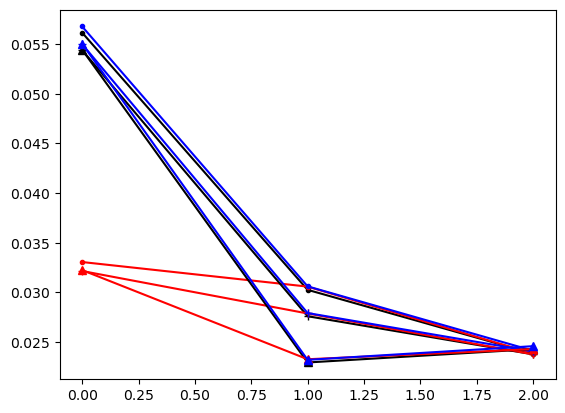

In [18]:
for i in range(len(modDirs)):
    plt.plot(UBRMSE1[i,:],'k'+symbs[i]+'-')
    plt.plot(UBRMSE2[i,:],'r'+symbs[i]+'-')
    plt.plot(stddev1[i,:],'b'+symbs[i]+'-')
# plt.xlabel('DSG','PMI','TSR')

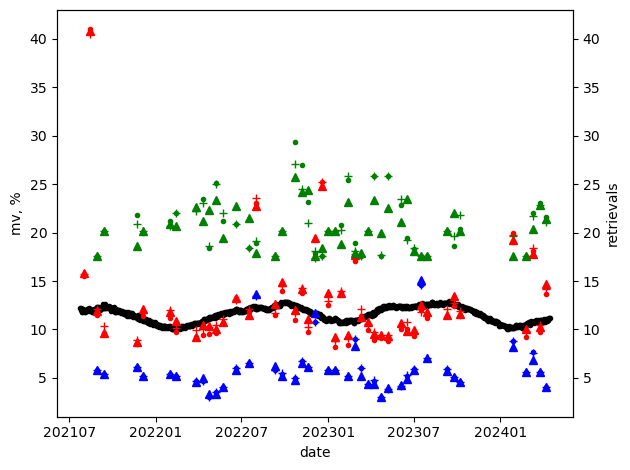

In [19]:
xticks=[]
[xticks.append([datetime.datetime(y,1,1),datetime.datetime(y,7,1)]) for y in range(year0,yearN+1)]
xticks = sum(xticks, []) #this flattens the above list

myFmt = DateFormatter("%Y%m")
fig, ax1 = plt.subplots()

ax1.set_xlabel('date')
ax1.set_ylabel('mv, %', color='k')
ax1.plot(dfdn,data_df['SMS_DAILY'], 'k.')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xticks(xticks)
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylim([minval,maxval])

ax2 = ax1.twinx()             # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('retrievals')  # we already handled the x-label with ax1
for i in range(len(modDirs)):
    for j in range(3):
        ax2.plot(dates,retr[i,:,j]*100,cols[j]+symbs[i])
ax2.tick_params(axis='y')
ax2.set_ylim([minval,maxval])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

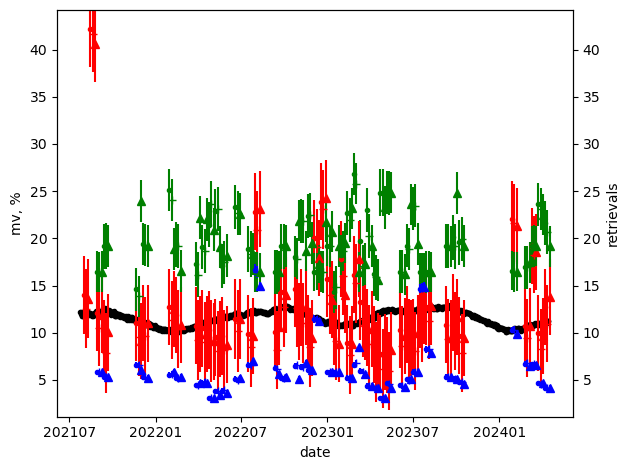

In [20]:
xticks=[]
[xticks.append([datetime.datetime(y,1,1),datetime.datetime(y,7,1)]) for y in range(year0,yearN+1)]
xticks = sum(xticks, []) #this flattens the above list

myFmt = DateFormatter("%Y%m")
fig, ax1 = plt.subplots()

ax1.set_xlabel('date')
ax1.set_ylabel('mv, %', color='k')
ax1.plot(dfdn,data_df['SMS_DAILY'], 'k.')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xticks(xticks)
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylim([minval,maxval])


ax2 = ax1.twinx()             # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('retrievals')  # we already handled the x-label with ax1
for i in range(len(modDirs)):
    for j in range(3):
        ax2.errorbar(dates+datetime.timedelta(days=i*5),retr[i,:,j]*100,yerr=rete[i,:,j]*100,fmt=cols[j]+symbs[i])
ax2.tick_params(axis='y')
ax2.set_ylim([minval,maxval])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Text(0, 0.5, 'sigma0HH, aggregated')

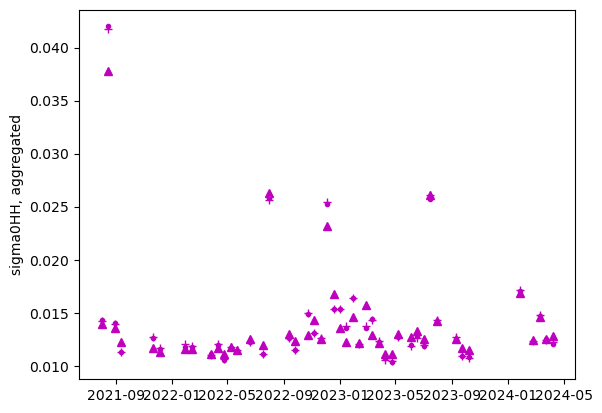

In [21]:
fig,ax1=plt.subplots()
for i in range(len(modDirs)):
    ax1.plot(dates,HH[i,:],'m'+symbs[i] )
ax1.set_ylabel('sigma0HH, aggregated')


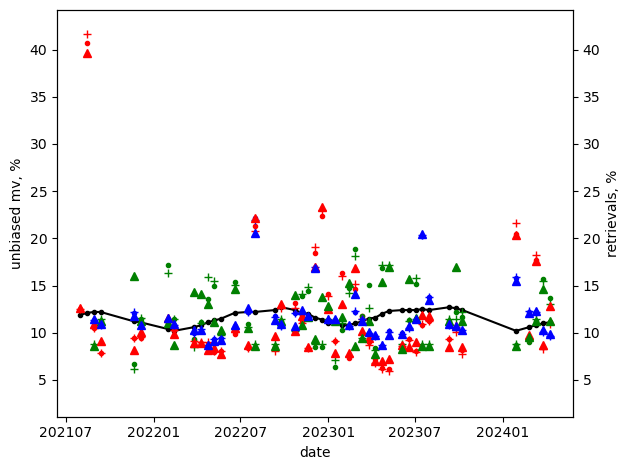

In [22]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('date')
ax1.set_ylabel('unbiased mv, %', color='k')
ln1=ax1.plot(insituDates,insituData, 'k.-')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xticks(xticks)
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_ylim([minval,maxval])
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('retrievals, %')  # we already handled the x-label with ax1

for i in range(len(modDirs)):
    for j in range(3):
        ax2.plot(dates,(retr[i,:,j]-bias[i,j])*100,cols[j]+symbs[i] )

ax2.tick_params(axis='y')
ax2.set_ylim([minval,maxval])
#plt.xticks([datetime.datetime(2022,1,1),datetime.datetime(2022,7,1),datetime.datetime(2023,1,1),datetime.datetime(2023,7,1)])
#ax2.legend(ln1+ln2,('in situ','DSG','PMI','TSR','DSG2'))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

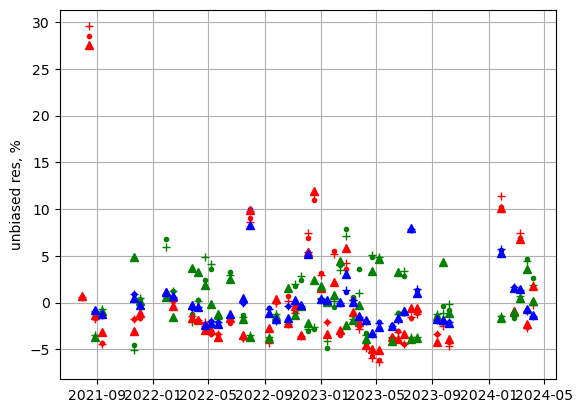

In [23]:
for i in range(len(modDirs)):
    for j in range(3):
        plt.plot(dates,ubres[i,:,j]*100,cols[j]+symbs[i] )

plt.tight_layout
plt.grid('on')

# plt.legend()
plt.ylabel('unbiased res, %')
plt.show()